In [1]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import random
import os
import argparse
from sklearn.metrics import precision_recall_curve

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

# dnase_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtl_preds/snp_scores.tsv"
# atac_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtl_preds/snp_scores.tsv"
# atac_preds_250m="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_250M/dsqtl_preds/snp_scores.tsv"
# atac_preds_100m="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_100M/dsqtl_preds/snp_scores.tsv"
# atac_preds_50m="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_50M/dsqtl_preds/snp_scores.tsv"
# atac_preds_25m="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_25M/dsqtl_preds/snp_scores.tsv"
# atac_preds_5m="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/subsampling/GM12878_5M/dsqtl_preds/snp_scores.tsv"

main_dir="/mnt/lab_data2/anusri/variant-scorer/src/output/dsqtls_lcl/"
dnase_preds=main_dir+"DNASE/summary.mean.variant_scores_new_2.tsv"
atac_preds=main_dir+"ATAC/summary.mean.variant_scores_new_2.tsv"
atac_preds_250m=main_dir+"ATAC_250M/summary.mean.variant_scores_new_2.tsv"
atac_preds_100m=main_dir+"ATAC_100M/summary.mean.variant_scores_new_2.tsv"
atac_preds_50m=main_dir+"ATAC_50M/summary.mean.variant_scores_new_2.tsv"
atac_preds_25m=main_dir+"ATAC_25M/summary.mean.variant_scores_new_2.tsv"
atac_preds_5m=main_dir+"ATAC_5M/summary.mean.variant_scores_new_2.tsv"
gkm_svm = pd.read_csv("/mnt/lab_data3/anusri/histone_expts/all_qtl_analysis/gm12878_sequence_sets/test_set/deltasv,/41588_2015_BFng3331_MOESM26_ESM.csv",header=0,sep=',')

In [2]:
gkm_svm.head()

,chrom_hg18,pos_hg18,SNPname1,chrom_hg19,pos_hg19,SNPname2,allele1,allele2,gkm_SVM,kmer_SVM,abs_gkm_SVM,abs_kmer_SVM,CADD,GWAVA_region,GWAVA_tss,GWAVA_unmatched,GERP,label
0,chr1,846446,chr1.846446,chr1,856583,rs141671872,A,G,2.653531,7.938784,2.653531,7.938784,-1.522533,0.48,0.53,0.75,-0.682,1
1,chr1,901458,chr1.901458,chr1,911595,rs7417106,G,A,2.821422,6.027648,2.821422,6.027648,1.739152,0.29,0.36,0.89,2.150,1
2,chr1,1176365,chr1.1176365,chr1,1186502,rs6603785,T,A,-7.167236,-10.870018,7.167236,10.870018,-0.091378,0.42,0.49,0.66,0.451,1
3,chr1,1217275,chr1.1217275,chr1,1227412,rs112571439,A,G,-3.957382,2.387491,3.957382,2.387491,1.127472,0.34,0.43,0.49,2.430,1
4,chr1,1580438,chr1.1580438,chr1,1590575,rs9661285,A,G,-4.785596,-6.827102,4.785596,6.827102,0.665464,0.38,0.35,0.86,1.640,1


In [3]:
# def fetch_auprc(preds):
#     dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
#     dsqtls[['gkm_SVM','kmer_SVM','abs_gkm_SVM','abs_kmer_SVM','CADD','GWAVA_region','GWAVA_tss','GWAVA_unmatched','GERP','label']] = dsqtls['META_DATA'].str.split(",", expand=True)
#     dsqtls["label"] = dsqtls["label"].astype(int)
#     fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(dsqtls["label"], abs(dsqtls["log_probs_diff_abs_sum"]))
#     roc_auc = metrics.average_precision_score(dsqtls["label"], abs(dsqtls["log_probs_diff_abs_sum"]))
#     return roc_auc
    
def fetch_auprc_new(preds):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    print(dsqtls.shape)
    print(gkm_svm.shape)
    merged_atac = dsqtls.merge(gkm_svm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    print(merged_atac.shape)
    merged_atac["label"] = merged_atac["label"].astype(int)
    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_atac["label"], abs(merged_atac["abs_logfc_x_jsd_x_max_percentile.mean"]))
    roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac["abs_logfc_x_jsd_x_max_percentile.mean"]))
    #roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac["jsd.mean"]))

    return roc_auc
       
    

In [6]:
# roc_500m = fetch_auprc(atac_preds)
# roc_250m = fetch_auprc(atac_preds_250m)
# roc_100m = fetch_auprc(atac_preds_100m)
# roc_50m = fetch_auprc(atac_preds_50m)
# roc_25m = fetch_auprc(atac_preds_25m)
# roc_5m = fetch_auprc(atac_preds_5m)
# roc_dnase = fetch_auprc(dnase_preds)


roc_500m = fetch_auprc_new(atac_preds)
roc_250m = fetch_auprc_new(atac_preds_250m)
roc_100m = fetch_auprc_new(atac_preds_100m)
roc_50m = fetch_auprc_new(atac_preds_50m)
roc_25m = fetch_auprc_new(atac_preds_25m)
roc_5m = fetch_auprc_new(atac_preds_5m)
roc_dnase = fetch_auprc_new(dnase_preds)


(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)


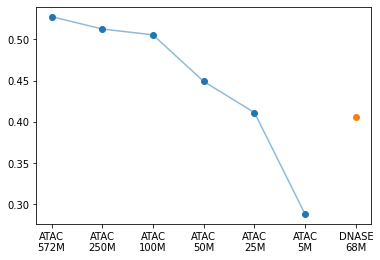

In [7]:
plt.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m])
plt.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M","ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m], alpha=0.5)
plt.scatter(["DNASE\n68M"], [roc_dnase])
plt.savefig("subfigs_new/subsample_profile_performance.pdf", transparent=True, dpi=300)





In [8]:
def fetch_auprc(preds):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    dsqtls[['gkm_SVM','kmer_SVM','abs_gkm_SVM','abs_kmer_SVM','CADD','GWAVA_region','GWAVA_tss','GWAVA_unmatched','GERP','label']] = dsqtls['META_DATA'].str.split(",", expand=True)
    dsqtls["label"] = dsqtls["label"].astype(int)
    fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(dsqtls["label"], abs(dsqtls["log_counts_diff"]))
    roc_auc = metrics.average_precision_score(dsqtls["label"], abs(dsqtls["log_counts_diff"]))
    return roc_auc
    
    

In [9]:
roc_500m = fetch_auprc_new(atac_preds)
roc_250m = fetch_auprc_new(atac_preds_250m)
roc_100m = fetch_auprc_new(atac_preds_100m)
roc_50m = fetch_auprc_new(atac_preds_50m)
roc_25m = fetch_auprc_new(atac_preds_25m)
roc_5m = fetch_auprc_new(atac_preds_5m)
roc_dnase = fetch_auprc_new(dnase_preds)


(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)
(28309, 24)
(28309, 18)
(28309, 40)


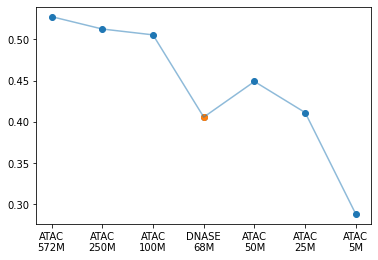

In [10]:
plt.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M", "DNASE\n68M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_dnase,roc_50m,roc_25m,roc_5m])
plt.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M", "DNASE\n68M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_dnase,roc_50m,roc_25m,roc_5m], alpha=0.5)
plt.scatter(["DNASE\n68M"], [roc_dnase])

#plt.savefig("subfigs/subsample_counts_performance.pdf", transparent=True, dpi=300)




In [11]:
es = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/dsqtls_lcl/dsqtl_effect_size.txt", sep="\t")

In [12]:
es.head()
es["rsid"] = es["Chr"]+"."+es["SNP"].astype(str)

In [13]:
es

,Chr,Start,End,SNP,Estimate,Std. Error,t value,Pr(>|t|),rsid
0,chr1,802000,802100.0,801099,1.3980,0.35600,3.926,2.043000e-04,chr1.801099
1,chr1,846400,846500.0,846446,0.9301,0.17900,5.197,2.013000e-06,chr1.846446
2,chr1,901300,901400.0,901912,-0.6247,0.15260,-4.094,1.148000e-04,chr1.901912
3,chr1,901400,901500.0,901458,-0.6285,0.08721,-7.207,6.010000e-10,chr1.901458
4,chr1,905000,905100.0,904803,-0.7331,0.17580,-4.169,8.843000e-05,chr1.904803
...,...,...,...,...,...,...,...,...,...
6065,chr22,48975800,48975900.0,48975897,-0.4515,0.13100,-3.445,9.825000e-04,chr22.48975897
6066,chr22,49041600,49041700.0,49041614,-0.3606,0.09483,-3.802,3.092000e-04,chr22.49041614
6067,chr22,49082800,49082900.0,49083204,1.0370,0.26980,3.842,2.710000e-04,chr22.49083204
6068,chr22,49333100,49333200.0,49332654,-1.2440,0.32090,-3.877,2.406000e-04,chr22.49332654


In [106]:
import scipy.stats
def fetch_pearsonr_new(preds):
    dsqtls = pd.read_csv(preds,sep="\t", header=0, index_col=False)
    pc_comp = get_pc_component(dsqtls)
    dsqtls["pc_comp"] = pc_comp
    print(dsqtls.shape)
    print(gkm_svm.shape)
    
    n_gkm = gkm_svm[gkm_svm["label"]==1]
    n_gkm = n_gkm.merge(es, left_on=["SNPname1"], right_on='rsid')
    n_gkm.shape
    merged_atac = dsqtls.merge(n_gkm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
    merged_atac["sign.jsd.mean"] = merged_atac["jsd.mean"]*np.sign(merged_atac["logfc.mean"])*-1
    print(merged_atac.shape)
    pearsonr_val = scipy.stats.pearsonr(merged_atac["pc_comp"]*-1, merged_atac["Estimate"])[0]
    print( scipy.stats.pearsonr(merged_atac["pc_comp"] *-1, merged_atac["Estimate"]))
    return pearsonr_val
   #roc_auc = metrics.average_precision_score(merged_atac["label"], abs(merged_atac["jsd.mean"]))


In [104]:
gkm_svm.shape

(28309, 18)

In [105]:
from sklearn.decomposition import PCA
import scipy.stats

def get_pc_component(df1):
    val1 = df1["jsd.mean"].astype(float)*np.sign(df1['logfc.mean'].astype(float))
    val2 = df1["logfc.mean"].astype(float)
    val3 = df1["jsd.mean"].astype(float)*df1['logfc.mean'].astype(float)
    val4 = df1["log_prob_log2s.mean"].astype(float)*df1['logfc.mean'].astype(float)

    values = [val2, val3]
    values = np.transpose(values)
    mean_axis = np.mean(values, axis=1)
    new_values = PCA(n_components=1).fit_transform(X=values)
    
    if scipy.stats.pearsonr(new_values[:,0], mean_axis)[0] > 0:
        return new_values[:,0]
    else:
        return new_values[:,0]*-1

roc_500m = fetch_pearsonr_new(atac_preds)
roc_250m = fetch_pearsonr_new(atac_preds_250m)
roc_100m = fetch_pearsonr_new(atac_preds_100m)
roc_50m = fetch_pearsonr_new(atac_preds_50m)
roc_25m = fetch_pearsonr_new(atac_preds_25m)
roc_5m = fetch_pearsonr_new(atac_preds_5m)
roc_dnase = fetch_pearsonr_new(dnase_preds)


(28309, 25)
(28309, 18)
(573, 51)
(-0.7434338847859769, 7.929452369781007e-102)
(28309, 25)
(28309, 18)
(573, 51)
(-0.7481599323797763, 8.450905648554289e-104)
(28309, 25)
(28309, 18)
(573, 51)
(-0.7432867751936212, 9.118835467297648e-102)
(28309, 25)
(28309, 18)
(573, 51)
(-0.7328011065482104, 1.5200131846418242e-97)
(28309, 25)
(28309, 18)
(573, 51)
(-0.722337851955676, 1.5841608876975079e-93)
(28309, 25)
(28309, 18)
(573, 51)
(-0.6701745148909097, 5.820630900061512e-76)
(28309, 25)
(28309, 18)
(573, 51)
(-0.7478832203392873, 1.1055970599803303e-103)


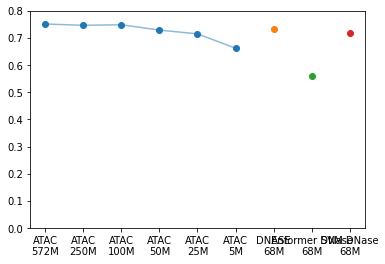

In [80]:
plt.figure()
plt.scatter(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M" ,"ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m])
plt.plot(["ATAC\n572M", "ATAC\n250M", "ATAC\n100M","ATAC\n50M", "ATAC\n25M", "ATAC\n5M"],[roc_500m,roc_250m,roc_100m,roc_50m,roc_25m,roc_5m], alpha=0.5)
plt.scatter(["DNASE\n68M"], [roc_dnase])
plt.scatter(["Enformer DNase\n68M"], [0.56])
plt.scatter(["SVM DNase\n68M"], [0.72])

plt.ylim((0,0.8))
plt.savefig("subfigs_new/subsample_pearsonr_performance.pdf", transparent=True, dpi=300)


In [81]:
n_gkm = gkm_svm[gkm_svm["label"]==1]
n_gkm = n_gkm.merge(es, left_on=["SNPname1"], right_on='rsid')



In [82]:
scipy.stats.pearsonr(n_gkm["gkm_SVM"],n_gkm["Estimate"])

(0.7280057455461137, 1.1132173119906522e-95)

In [83]:
enformer_ids = pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/results/variant_data/dsqtls/process/fetch_enformer/enformer_predictions.tsv", sep="\t", header=0)

In [84]:
merged_enf_1 = enformer_ids.merge(n_gkm, left_on=["rsid", "chr", "pos", "ref", "alt"], right_on=["SNPname2", "chrom_hg19", "pos_hg19", "allele2", "allele1"])
merged_enf_2 = enformer_ids.merge(n_gkm, left_on=["rsid", "chr", "pos", "ref", "alt"], right_on=["SNPname2", "chrom_hg19", "pos_hg19", "allele1", "allele2"])
merged_enf_2["DNASE_SAD"] = merged_enf_2["DNASE_SAD"]*-1
merged_enf_2["DNASE_SAR"] = merged_enf_2["DNASE_SAR"]*-1

In [85]:
merged_enf = pd.concat([merged_enf_1, merged_enf_2]).drop_duplicates()

In [86]:
merged_enf.shape

(560, 34)

In [87]:
scipy.stats.pearsonr(merged_enf["DNASE_SAD"],merged_enf["Estimate"])

(0.5549551237929846, 1.5010306000678956e-46)

In [88]:
scipy.stats.pearsonr(merged_enf["DNASE_SAR"],merged_enf["Estimate"])

(0.5631287804191751, 3.62503784193437e-48)

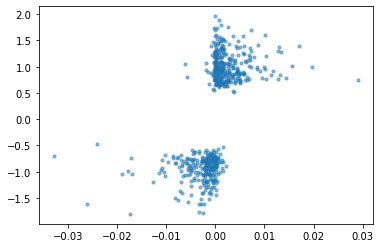

In [89]:
plt.scatter(merged_enf["DNASE_SAR"],merged_enf["Estimate"], alpha=0.5, s=10)

In [90]:
scipy.stats.pearsonr(merged_enf["DNASE_SAD"],merged_enf["Estimate"])

(0.5549551237929846, 1.5010306000678956e-46)

In [91]:
dsqtls = pd.read_csv(atac_preds,sep="\t", header=0, index_col=False)
print(dsqtls.shape)
print(gkm_svm.shape)

n_gkm = gkm_svm[gkm_svm["label"]==1]
n_gkm = n_gkm.merge(es, left_on=["SNPname1"], right_on='rsid')
n_gkm.shape
merged_atac = dsqtls.merge(n_gkm, left_on=['chr', 'pos', 'allele1', 'allele2'], right_on=["chrom_hg19", "pos_hg19", "allele1", "allele2"], how="inner")
merged_atac["sign.jsd.mean"] = merged_atac["jsd.mean"]*np.sign(merged_atac["logfc.mean"])*-1





(28309, 24)
(28309, 18)


   sd_sign.mean    Beta  max_percentile.mean
0      0.108381  0.9301             0.483655
1     -0.061612 -0.6285             0.781544
2     -0.054349 -0.7363             0.739015
3     -0.317087 -0.9236             0.714120
4     -0.064704 -1.0890             0.992978


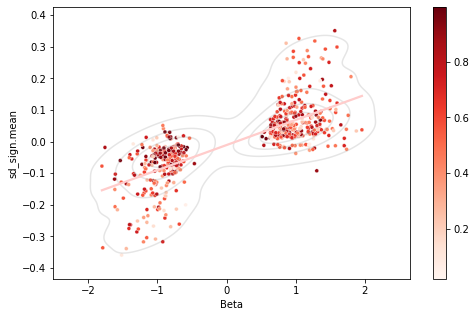

In [92]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 


data = pd.DataFrame()
data["sd_sign.mean"] = merged_atac["sign.jsd.mean"]
data["Beta"] = merged_atac["Estimate"]
data["max_percentile.mean"] = abs(merged_atac["max_percentile.mean"])
data = data.reset_index(drop=True)
print(data.head())
plt.figure(figsize=(8,5))

sns.kdeplot(
    data=data,
    x="Beta",
    y="sd_sign.mean",
    levels=5,
    fill=False,
    alpha=0.2,
    color="grey",
    cut=2,

)
ax = sns.scatterplot(x="Beta", y="sd_sign.mean", hue="max_percentile.mean", data=data, s=15, palette="Reds")
sns.regplot(x="Beta", y="sd_sign.mean", data=data, scatter=False, ci=None, color="#ffcccb")
#sns.jointplot(x=data["Beta"], y=data["sd_sign.mean"],s=0,ax=ax)

norm = plt.Normalize(data['max_percentile.mean'].min(), data['max_percentile.mean'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)


plt.savefig("subfigs_new/dsqtls_scatter_plot.pdf", transparent=True, dpi=300)

   sd_sign.mean    Beta  max_percentile.mean
0      0.692179  0.9301             0.483655
1     -0.118311 -0.6285             0.781544
2     -0.862356 -0.7363             0.739015
3     -1.762505 -0.9236             0.714120
4     -0.275676 -1.0890             0.992978


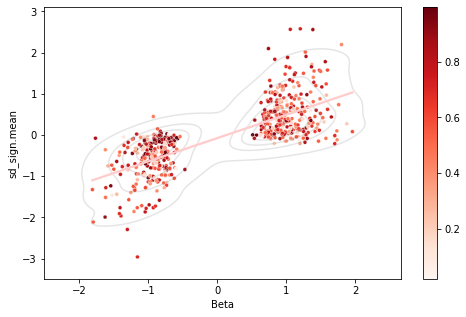

In [93]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 


data = pd.DataFrame()
data["sd_sign.mean"] = get_pc_component(merged_atac)*-1
data["Beta"] = merged_atac["Estimate"]
data["max_percentile.mean"] = abs(merged_atac["max_percentile.mean"])
data = data.reset_index(drop=True)
print(data.head())
plt.figure(figsize=(8,5))

sns.kdeplot(
    data=data,
    x="Beta",
    y="sd_sign.mean",
    levels=5,
    fill=False,
    alpha=0.2,
    color="grey",
    cut=2,

)
ax = sns.scatterplot(x="Beta", y="sd_sign.mean", hue="max_percentile.mean", data=data, s=15, palette="Reds")
sns.regplot(x="Beta", y="sd_sign.mean", data=data, scatter=False, ci=None, color="#ffcccb")
#sns.jointplot(x=data["Beta"], y=data["sd_sign.mean"],s=0,ax=ax)

norm = plt.Normalize(data['max_percentile.mean'].min(), data['max_percentile.mean'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)